Please enter the traffic jam amount.
> 0
Please enter the obstacle amount.
> 0
Activate the base staion?(y/n) 
> yes
YES


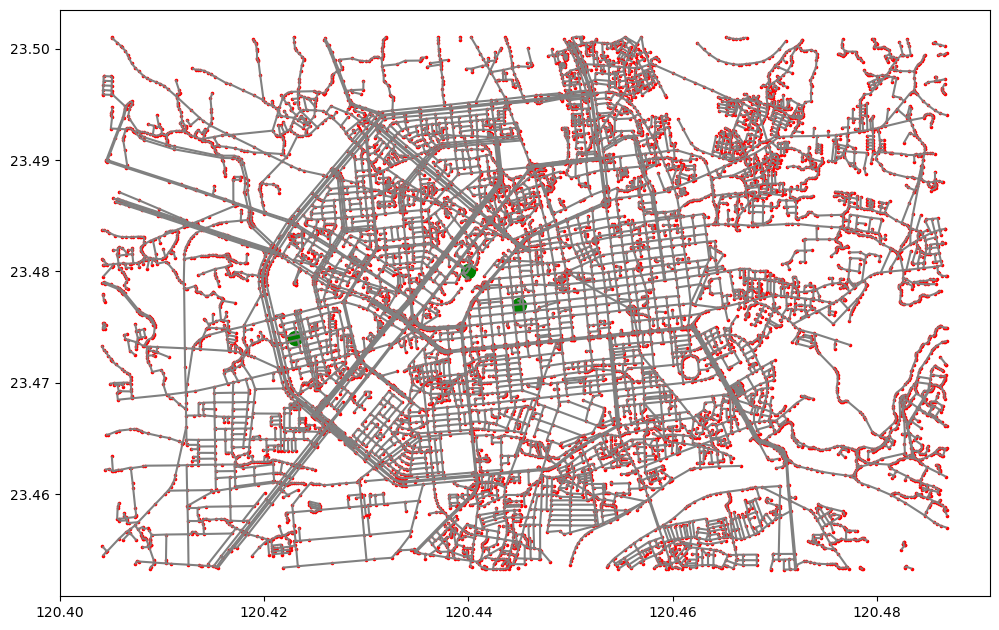

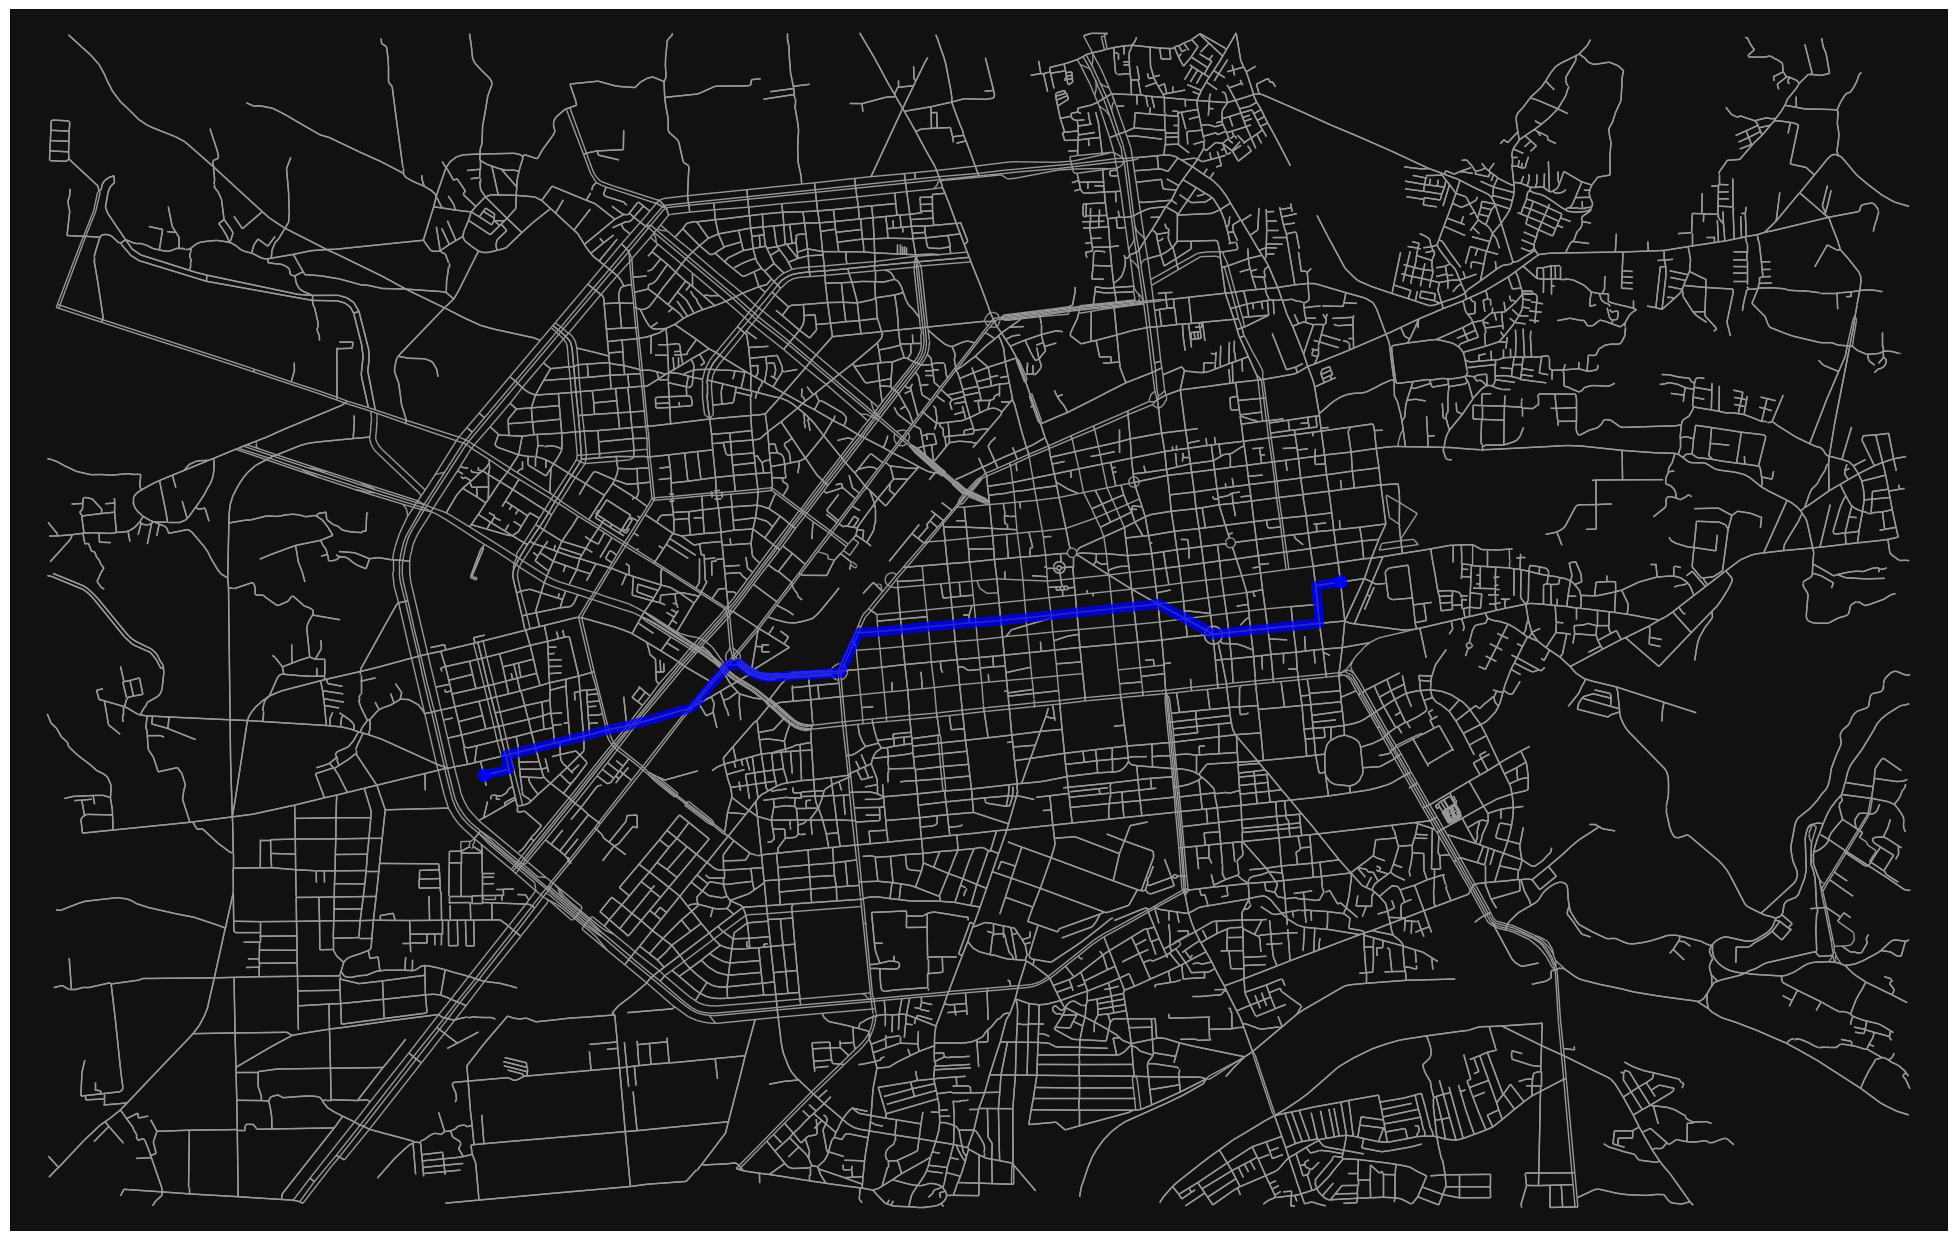

Current time: Sat Apr 20 18:06:12 2024
Traffic statement: normal
Current weather in Chiayi City is : Sunny.
Estimated distance: 4459.315000m.
Estimated Driving Time: 8min 55sec
Weight: 4299.594000m
Execution Time: 8.473412s


In [1]:
from pyrosm import OSM
from pyrosm import get_data
import osmnx as ox
import networkx as nx
import random
import time
from datetime import datetime, timedelta
from pymeteosource.api import Meteosource
from pymeteosource.types import tiers
from pymeteosource.types import sections, langs, units
import requests
from math import *

def dist(u, v):
    '''change node to geocode'''
    #u geocode
    x1 = G2.nodes[u]['x'] #'lon'
    y1 = G2.nodes[u]['y'] #'lat'
    #v geocode 
    x2 = G2.nodes[v]['x'] #'lon'
    y2 = G2.nodes[v]['y'] #'lat'
    return ((x1-x2)**2 + (y1-y2)**2)**(0.5)

def bs_dist(u, base_x, base_y):
    '''change node to geocode'''
    #u geocode
    x1 = G2.nodes[u]['x'] #'lon'
    y1 = G2.nodes[u]['y'] #'lat'
    x1, y1, base_x, base_y = map(radians, [x1, y1, base_x, base_y])
    dlon = base_x - x1 
    dlat = base_y - y1
    d = 2 * asin(sqrt((sin(dlat/2)**2) + cos(y1)*cos(base_y)*(sin(dlon/2)**2)))
    return d * 6371

'''set time'''
today = datetime.now()
cur_time_hour = today.strftime("%H")
cur_time_minute = today.strftime("%M")
'''end of set time'''

'''set up traffic jam amount'''
'''
if cur_time_hour == 7 and cur_time_minute <= 30:
    traffic_jam_amount = 150 # heavy traffic
    traffic_statement = 'heavy'
elif cur_time_hour == 12 and cur_time_minute <= 30:
    traffic_jam_amount = 100
    traffic_statement = 'medium'
elif cur_time_hour == 17 and cur_time_minute <= 30:
    traffic_jam_amount = 200 # heavy traffic
    traffic_statement = 'heavy'
elif (cur_time_hour == 22 and cur_time_minute >= 30) or (cur_time_hour == 23 and cur_time_minute == 0):
    traffic_jam_amount = 20
    traffic_statement = 'sparse'
else:
    traffic_jam_amount = 50
    traffic_statement = 'normal'
'''

traffic_statement = 'normal'


'''Set up weather'''
api_key = 'ef1l5lcvli6htfowzakm9ehraylk9kytzkzb50zd'
tier = tiers.FLEXI
meteosource = Meteosource(api_key, tier)

#location = input('Please Enter Your Current Area ')
#if location == '':
location = 'Chiayi'

location_url = 'https://www.meteosource.com/api/v1/free/find_places?text=' + location + '&key=ef1l5lcvli6htfowzakm9ehraylk9kytzkzb50zd'
location_data = requests.get(location_url).json()


parameters = {'key': 'ef1l5lcvli6htfowzakm9ehraylk9kytzkzb50zd',
              'place_id': location_data[0]['place_id'] }

weather_url = "https://www.meteosource.com/api/v1/free/point"
weather_data = requests.get(weather_url, parameters).json()

'''End of set up '''


#traffic_jam_amount = 0
#traffic_jam_amount = int(input('Traffic jam amount: '))
'''end of set up traffic jam amount'''

while True:
    traffic_jam_amount = int(input('Please enter the traffic jam amount.\n> '))
    if traffic_jam_amount < 0:  
        print('Invalid value, please enter again.')
        continue
    else:
        break

while True:
    ob_num = int(input('Please enter the obstacle amount.\n> '))
    if ob_num < 0:  
        print('Invalid value, please enter again.')
        continue
    else:
        break
        
while True:
    activate_option = input('Activate the base staion?(y/n) \n> ').upper()
    if activate_option != "Y" and activate_option != "YES" and activate_option != "N" and activate_option != "NO":
        print('Invalid value, please enter again.')
        continue
    else:
        break
        
''' start '''

st_time=time.time()

'''bulid Graph'''
path = "./Chiayi.pbf"

# Initialize the OSM parser object
osm = OSM(path)

nodes, edges = osm.get_network(nodes=True, network_type="driving")

# Plot nodes and edges on a map
ax = edges.plot(figsize=(12,12), color="gray")
ax = nodes.plot(ax=ax, color="red", markersize=2.5)

# Create a graph for igraph from nodes and edges
G = osm.to_graph(nodes, edges, graph_type="networkx")
G2 = G.copy() 
# Show the graph
# ox.plot_graph(G)

'''set variables only for Chiayi'''
road_num = 17559 #total road number !!do NOT change it!!

source_x = 120.424
source_y = 23.471
target_x = 120.462
target_y = 23.479

base1_x = 120.445 
base1_y = 23.477
base2_x = 120.44
base2_y = 23.48
base3_x = 120.423
base3_y = 23.474


'''這裡以下可以直接複製到其他地圖'''
'''change length of edges (if base station nearby)'''
rt_length = [0]*road_num
for i in range(road_num):
    rt_length[i] = edges.iloc[i]['length']

'''randomly create obstacles'''
ob = 0
rm_str = []

rm_str = random.sample(range(road_num),ob_num)
route_lst = []
for i in range(ob_num): 
    u=edges.iloc[rm_str[i]]['u']
    v=edges.iloc[rm_str[i]]['v']
    if G.has_edge(u,v):
        rt_length[rm_str[i]]*=99999
        rt=[u]
        rt.append(v)
        route_lst.append(rt)
        G2.remove_edge(u,v)
        ob += 1
'''End of create obstacles'''

'''random create traffic jam'''
traffic_jam = 0
traffic_jam_str = []

traffic_jam_str = random.sample(range(road_num), traffic_jam_amount)
for i in range(traffic_jam_amount): 
    u=edges.iloc[traffic_jam_str[i]]['u']
    v=edges.iloc[traffic_jam_str[i]]['v']
    if G2.has_edge(u,v):
        rt_length[traffic_jam_str[i]]*=2 # simulate traffic jam
        rt=[u]
        rt.append(v)
        route_lst.append(rt)
        traffic_jam += 1
'''end of create traffic jam'''

'''create base station'''
if activate_option == 'Y' or 'YES':
    for i in range(road_num): 
        u = edges.iloc[i]['u']
        v = edges.iloc[i]['v']
        if G2.has_edge(u,v):
            if (bs_dist(u, base1_x, base1_y) <= 0.1) or (bs_dist(v, base1_x, base1_y) <= 0.1) or \
                (bs_dist(u, base2_x, base2_y) <= 0.1) or (bs_dist(v, base2_x, base2_y) <= 0.1) or \
                (bs_dist(u, base3_x, base3_y) <= 0.1) or (bs_dist(v, base3_x, base3_y) <= 0.1):
                    rt_length[i] *= 0.5
'''end of create base station'''

ed_weights = {}
'''Assume in rainy day, highway speed is limited up to 80.
    And in light rain or fog, speed limit is 90'''

if(weather_data['current']['summary'] == 'Rain'):
    avg_driving_speed = 20.0
    for i in range(road_num): 
        u=edges.iloc[i]['u']
        v=edges.iloc[i]['v']
        if edges.iloc[i]['highway'] == 'trunk':
            ed_weights[u,v,0] = rt_length[i]*avg_driving_speed/80.0
        else:
            ed_weights[u,v,0] = rt_length[i]
elif (weather_data['current']['summary'] =='Light rain' or weather_data['current']['summary'] =='Fog'):
    avg_driving_speed = 25.0
    for i in range(road_num): 
        u=edges.iloc[i]['u']
        v=edges.iloc[i]['v']
        if edges.iloc[i]['highway'] == 'trunk':
            ed_weights[u,v,0] = rt_length[i]*avg_driving_speed/90.0
        else:
            ed_weights[u,v,0] = rt_length[i]   
else:
    avg_driving_speed = 30.0
    for i in range(road_num): 
        u=edges.iloc[i]['u']
        v=edges.iloc[i]['v']
        if edges.iloc[i]['highway'] == 'trunk':
            ed_weights[u,v,0] = rt_length[i]*avg_driving_speed/100.0
        else:
            ed_weights[u,v,0] = rt_length[i]

nx.set_edge_attributes(G2, values = ed_weights, name = 'length')


'''find closest nodes of source and target'''
source_node = ox.nearest_nodes(G2, source_x, source_y)
target_node = ox.nearest_nodes(G2, target_x, target_y)

'''find shortest path'''
route = nx.astar_path(G2, source_node, target_node, heuristic=dist, weight='length')
'''end of finding shortest path'''

'''output graph with route'''
route_lst.append(route)
route_lst.append(route)

'''debug'''
# = len(route_lst)
#print('n = %d, ob = %d, traffic_jam = %d' %(n, ob_num, traffic_jam))

ax.scatter(base1_x, base1_y, c='green', s=100)
ax.scatter(base2_x, base2_y, c='green', s=100)
ax.scatter(base3_x, base3_y, c='green', s=100)

rt_clr = ob * ['r'] + traffic_jam * ['y'] + ['b'] * 2

fig, ax2 = ox.plot_graph_routes(
    G, 
    route_lst, 
    route_colors = rt_clr,
    route_linewidths = 7,
    node_size = -1.5,
    figsize = (25,25))

'''current time'''
current_time = today.ctime()
print('Current time: ' + current_time)
print('Traffic statement: ' + traffic_statement)

'''estimated time (driving)'''
#Google map assume average speed at about 30~50km
#according to real time road conditions 
#1 (km/hr) = 5/18 (m/s)

print('Current weather in ' + location_data[0]['name'] + ' is : {}.'.format(weather_data['current']['summary']))

es_time = (nx.path_weight(G2, route,'length')/(avg_driving_speed*5/18))
esn_time = (nx.path_weight(G, route,'length')/(avg_driving_speed*5/18))
#print('Estimated Driving Time: %dmin %dsec' %((es_time//60),(round(es_time%60,0))))
print('Estimated distance: %fm.' %(nx.path_weight(G, route,'length')))
print('Estimated Driving Time: %dmin %dsec' %((esn_time//60),(round(esn_time%60,0))))
print('Weight: %fm' %(nx.astar_path_length(G2, source_node,target_node,weight='length')))
#print('Affected time: %dmin %dsec' % ((esn_time - es_time)//60, (round((esn_time - es_time)%60,0))))

'''program execution time'''
ed_time = time.time()
print('Execution Time: %fs' %(ed_time-st_time))

In [ ]:
target_node

In [ ]:
print(nx.path_weight(G2,route,'length'))
print(nx.astar_path_length(G,source_node,target_node,weight='length'))

In [ ]:
rt_length = [0]*17559
for i in range(17559):
    rt_length[i] = edges.iloc[i]['length']*0.8
    
for i in range(ob_num): 
    u=edges.iloc[rm_str[i]]['u']
    v=edges.iloc[rm_str[i]]['v']
    G[u][v]['weight'] = rt_length[i] 

In [ ]:
rt_length = [0]*17559
for i in range(17559):
    rt_length[i] = edges.iloc[i]['length']
ed_weights = {}
for i in range(17559): 
    u=edges.iloc[i]['u']
    v=edges.iloc[i]['v']
    ed_weights[u,v,i] = rt_length[i]
print(ed_weights)

In [ ]:
print(G2[route[182]][route[183]][0])

In [ ]:
print(nx.get_edge_attributes(G2,'key'))

In [ ]:
edges.iloc[60]

In [ ]:
nx.draw(G)